In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Import your dataset and transforms
from dataset_creater import *


In [18]:
# Set the path to your dataset
data_folder = "./data"
transform = Spectrogram_transform

# Create an instance of your dataset
dataset = AudioDataset(data_folder, transform=transform)

# Define the sizes of your splits
train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create training, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
# Move the training and validation data loaders to the selected device
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, shuffle=False)
test_loader = DataLoader(test_set, shuffle=False)

# Calculate the fc1 input size
for batch in train_loader:
    sample, label =  batch
    if len(sample.size()) == 3:
        fc1_input_size = sample.size(len(sample.size())-1)
        print(fc1_input_size)
    elif len(sample.size()) == 4:
        fc1_input_size = sample.size(len(sample.size())-1) * sample.size(len(sample.size())-2)
        print(fc1_input_size)
    break

25472


In [19]:
for batch in test_loader:
    padded_waveforms, labels = batch
    print("Padded waveforms shape:", padded_waveforms.shape)

Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128, 199])
Padded waveforms shape: torch.Size([1, 1, 128,

In [20]:
class ChordClassifier(nn.Module):
    def __init__(self):
        super(ChordClassifier, self).__init__()
        # Define a CNN with input shape is (batch_size, 1, 128, 199) and output shape is (batch_size, 1)
        # it should reduce the dimensionality very quickly because the dataset is small (<1000)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0) # shape (batch_size, 32, 124, 195)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2) # shape (batch_size, 32, 61, 97)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0) # shape (batch_size, 64, 57, 93)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=5, stride=2) # shape (batch_size, 64, 27, 45)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0) # shape (batch_size, 128, 23, 41)
        self.relu3 = nn.ReLU()
        # global average pooling
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1)) # shape (batch_size, 128, 1, 1)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128, 1) # no activation function because we use BCEWithLogitsLoss

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 128)
        x = self.bn3(x)
        x = self.dropout(x)
        x = self.fc1(x)
        # Use BCEWithLogitsLoss instead of BCELoss because it combines a Sigmoid layer and the BCELoss in one single class
        # the output shape should be (batch_size,)
        return x.view(-1)


'''


import torch.nn as nn

class ChordClassifier(nn.Module):
    def __init__(self):
        super(ChordClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        # Add more hidden layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        

        # Adjust the size of the fully connected layer
        self.fc1 = nn.Linear(24576, 512)  # Adapt this size based on your actual tensor size
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(128, 2)  # 2 classes: Major and Minor

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))

        x = x.view(x.size(0), -1)  # Flatten the tensor before fully connected layer

        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.fc3(x)

        return x
'''

'\n\n\nimport torch.nn as nn\n\nclass ChordClassifier(nn.Module):\n    def __init__(self):\n        super(ChordClassifier, self).__init__()\n\n        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)\n        self.relu1 = nn.ReLU()\n        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)\n        self.relu2 = nn.ReLU()\n        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        \n        # Add more hidden layers\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)\n        self.relu3 = nn.ReLU()\n        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)\n        self.relu4 = nn.ReLU()\n        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)\n        \n\n        # Adjust the size of the fully connected layer\n        self.fc1 = nn.Linear(24576, 512)  # Adapt this size based

In [21]:


# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and move it to the selected device
model = ChordClassifier().to(device)

# Instantiate loss function and move it to the selected device
criterion = nn.BCEWithLogitsLoss().to(device)

# Instantiate optimizer and move it to the selected device
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)



100%|██████████| 22/22 [00:08<00:00,  2.67it/s]


Training - Epoch 1/20, Loss: 0.6962, Accuracy: 0.5764
Validation - Epoch 1/20, Loss: 0.6853, Accuracy: 0.5647


100%|██████████| 22/22 [00:08<00:00,  2.69it/s]


Training - Epoch 2/20, Loss: 0.6495, Accuracy: 0.6215
Validation - Epoch 2/20, Loss: 0.6583, Accuracy: 0.5647


100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Training - Epoch 3/20, Loss: 0.6371, Accuracy: 0.6376
Validation - Epoch 3/20, Loss: 0.6450, Accuracy: 0.6353


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


Training - Epoch 4/20, Loss: 0.6101, Accuracy: 0.6623
Validation - Epoch 4/20, Loss: 1.1415, Accuracy: 0.4353


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


Training - Epoch 5/20, Loss: 0.6039, Accuracy: 0.6638
Validation - Epoch 5/20, Loss: 0.6984, Accuracy: 0.6000


100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Training - Epoch 6/20, Loss: 0.5721, Accuracy: 0.6972
Validation - Epoch 6/20, Loss: 0.7098, Accuracy: 0.5647


100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Training - Epoch 7/20, Loss: 0.5803, Accuracy: 0.6827
Validation - Epoch 7/20, Loss: 0.6482, Accuracy: 0.6471


100%|██████████| 22/22 [00:08<00:00,  2.63it/s]


Training - Epoch 8/20, Loss: 0.5450, Accuracy: 0.7205
Validation - Epoch 8/20, Loss: 0.6949, Accuracy: 0.6235


100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Training - Epoch 9/20, Loss: 0.5240, Accuracy: 0.7263
Validation - Epoch 9/20, Loss: 0.5831, Accuracy: 0.6588


100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Training - Epoch 10/20, Loss: 0.5097, Accuracy: 0.7336
Validation - Epoch 10/20, Loss: 0.6259, Accuracy: 0.6353


100%|██████████| 22/22 [00:08<00:00,  2.63it/s]


Training - Epoch 11/20, Loss: 0.4949, Accuracy: 0.7627
Validation - Epoch 11/20, Loss: 0.5539, Accuracy: 0.6706


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 12/20, Loss: 0.4793, Accuracy: 0.7700
Validation - Epoch 12/20, Loss: 0.5773, Accuracy: 0.6824


100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


Training - Epoch 13/20, Loss: 0.4443, Accuracy: 0.8035
Validation - Epoch 13/20, Loss: 0.5465, Accuracy: 0.6706


100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Training - Epoch 14/20, Loss: 0.4204, Accuracy: 0.8035
Validation - Epoch 14/20, Loss: 0.6852, Accuracy: 0.6118


100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


Training - Epoch 15/20, Loss: 0.4067, Accuracy: 0.8239
Validation - Epoch 15/20, Loss: 0.5445, Accuracy: 0.6824


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 16/20, Loss: 0.3884, Accuracy: 0.8370
Validation - Epoch 16/20, Loss: 0.5819, Accuracy: 0.7294


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Training - Epoch 17/20, Loss: 0.3940, Accuracy: 0.8297
Validation - Epoch 17/20, Loss: 0.6457, Accuracy: 0.6941


100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


Training - Epoch 18/20, Loss: 0.3849, Accuracy: 0.8239
Validation - Epoch 18/20, Loss: 0.6078, Accuracy: 0.6941


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 19/20, Loss: 0.3533, Accuracy: 0.8501
Validation - Epoch 19/20, Loss: 1.5944, Accuracy: 0.4471


100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Training - Epoch 20/20, Loss: 0.3302, Accuracy: 0.8675
Validation - Epoch 20/20, Loss: 0.6442, Accuracy: 0.7176
Testing - Accuracy: 0.6437


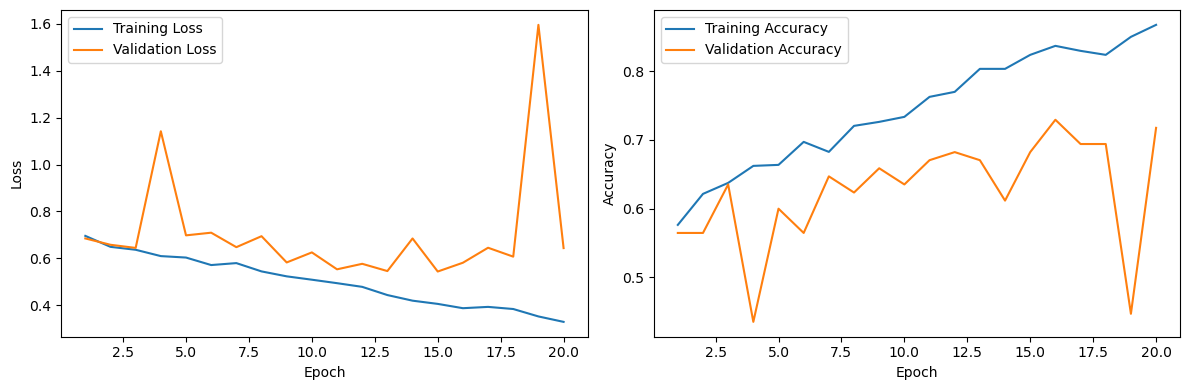

In [22]:
# Lists to store values for plotting
from cgi import test


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader):
        # convert labels to float because criterion requires float type labels
        labels = labels.type(torch.FloatTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs > 0.5
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_labels = val_labels.type(torch.FloatTensor)
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs > 0.5
            val_correct += (val_predicted == val_labels).sum().item()
            val_samples += val_labels.size(0)

    average_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples

    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {average_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_labels = test_labels.type(torch.FloatTensor)
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5
        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Plot learning curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


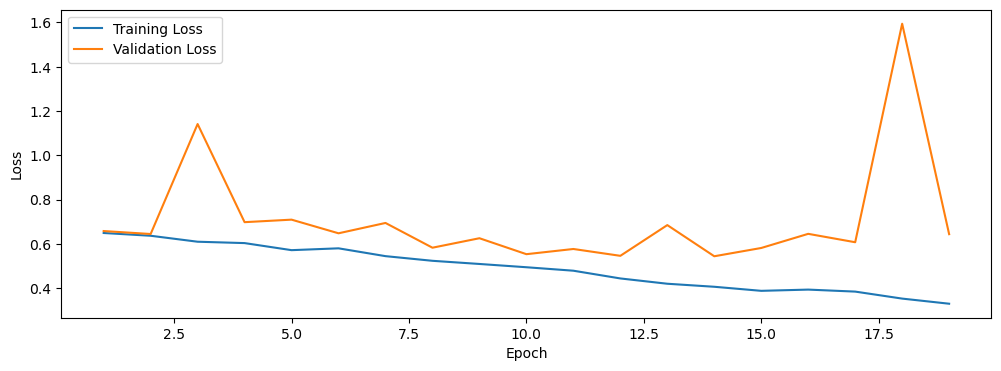

In [23]:
xrange = range(1, num_epochs)
plt.figure(figsize=(12, 4))
plt.plot(xrange, train_losses[1:], label='Training Loss')
plt.plot(xrange, val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Testing - Accuracy: 0.6437


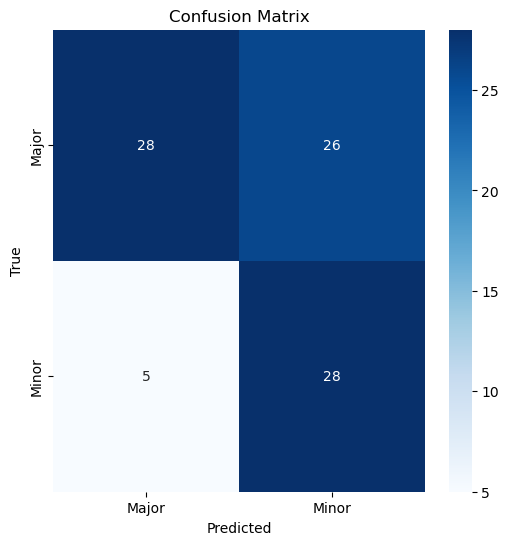

In [24]:
# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5

        true_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(test_predicted.cpu().numpy())

        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['Major', 'Minor']  # Modify based on your actual class names

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()